# **GraphSAGE** 
Made for the task of Node Regression (node attribute prediction).  
([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216))

## Installation

In [136]:
#LINUX
"""
!pip install torch==2.4.0
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install matplotlib
!pip install pandas
"""

'\n!pip install torch==2.4.0\ntorch_version = str(torch.__version__)\nscatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"\nsparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"\n!pip install torch-scatter -f $scatter_src\n!pip install torch-sparse -f $sparse_src\n!pip install torch-geometric\n!pip install matplotlib\n!pip install pandas\n'

In [137]:
# run these commands in py-venv if on WINDOWS
"""
pip install pandas
pip install matplotlib
"""

# CPU:
"""
pip install torch==2.4.0
pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.4.0.html
pip install torch-geometric
"""

# GPU:
"""
pip install torch==2.8.0+cu126 --index-url https://download.pytorch.org/whl/cu126
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
pip install torch_geometric -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
"""

'\npip install torch==2.8.0+cu126 --index-url https://download.pytorch.org/whl/cu126\npip install torch-scatter -f https://data.pyg.org/whl/torch-2.8.0+cu126.html\npip install torch_geometric -f https://data.pyg.org/whl/torch-2.8.0+cu126.html\n'

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

cuda
2.8.0+cu126
12.6
True


## GNN Stack Module

Below is the implementation of a general GNN stack, where we can plugin any GNN layer, such as **GraphSage**, **GAT**...

In [2]:
import os
import torch
import torch_geometric

c:\Users\stefi\Downloads\Code\MLG-Project\mlg-env\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  import torch_geometric.typing
c:\Users\stefi\Downloads\Code\MLG-Project\mlg-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, numeric_attr_dim, categories_list, encoder_out_emb_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()

        # Instantiate the AttributeEncoder as part of the GNNStack
        self.attribute_encoder = AttributeEncoder(numeric_attr_dim, categories_list, out_emb_dim=encoder_out_emb_dim)
        input_dim = encoder_out_emb_dim # The output of the attribute encoder is the input to the GNN

        # Build GNN layers
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))

        for l in range(args.num_layers-1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers
        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, numeric_data, cat_data_list, categories_list, edge_index, batch):
        # First, generate node features 'x' using the learnable AttributeEncoder
        x = self.attribute_encoder(numeric_data, cat_data_list, categories_list)

        # Then, pass 'x' through the GNN layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        if self.emb:
            return x

        x = self.post_mp(x)
        x = F.softplus(x)
        return x

    def loss(self, pred, label):
        return F.l1_loss(pred, label)

## GraphSAGE Implementation

In [4]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True, bias = False, **kwargs):

        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):

        # Computes aggregated neighbor embeddings for 
        # each node and adds self-node contribution
        out = self.propagate(edge_index, x=(x,x))
        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize: # optional normalization
          out = torch.nn.functional.normalize(out)

        return out

    # node attributes are sent to neighbors
    def message(self, x_j):
        out = x_j
        return out

    # mean aggregation of GraphSAGE
    def aggregate(self, inputs, index, dim_size = None):
        # inputs = messages(attributes) from neighbors
        # index = target node

        node_dim = self.node_dim # the axis along which to index number of nodes
        out = torch_scatter.scatter(inputs,index,node_dim,reduce="mean")

        return out


## Attribute Encoders

We use the CategoricalEncoder to put each categorical attribute through an MLP and create their embeddings. We concatenate them together with numerical attributes and push them through a final MLP in the AttributeEncoder. Numerical attributes are passed as is.

In [5]:
class CategoricalEncoder(nn.Module):
    def __init__(self, size):
        # size = list of all category sizes
        super().__init__()

        # dynamic MLP
        
        self.embedders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(i, int(i/2)), 
                nn.ReLU(), 
                nn.Linear(int(i/2),int(i/2))
            )
            for i in size
        ])
        """
        self.embedders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(i, i.bit_length()-1), 
                nn.ReLU(), 
                nn.Linear(i.bit_length()-1,i.bit_length()-1)
            )
            for i in size
        ])
        """

    # pushes categorical attributes as one-hot encodings through an MLP    
    def forward(self, id_list, n_classes):
        emb_out = []
        for mlp, ids, categories in zip(self.embedders, id_list, n_classes):
            #device = next(mlp.parameters()).device
            one_hot = F.one_hot(ids, num_classes=categories).float().to(device)
            emb = mlp(one_hot) # <-- [num_nodes, emb_dim]
            emb_out.append(emb)

        # concatenates them all together
        return torch.cat(emb_out, dim=1)
        
class AttributeEncoder(nn.Module):
    def __init__(self, val_cols, size, out_emb_dim=None):
        # val_cols = number of numeric attributes
        # size = list of all category sizes
        # out_emb_dim = dimension of the output embedding (final MLP)

        super().__init__()

        self.category_encoder = CategoricalEncoder(size)

        total_dim = 0
        for i in size:
            total_dim += int(i/2)
            #total_dim += (i.bit_length()-1)
        if out_emb_dim == None: # if no custom embedding is provided
            out_emb_dim = total_dim

        # final MLP
        self.mlp = nn.Sequential(
            nn.Linear(val_cols + total_dim, out_emb_dim),
            nn.ReLU(),
            nn.Linear(out_emb_dim, out_emb_dim)
        )

    def forward(self, val_attr, cat_attr, n_classes):
        # calls the CategoricalEncoder
        cat_emb = self.category_encoder(cat_attr, n_classes)
        x = torch.cat([val_attr, cat_emb], dim=1)
        
        # maybe the final MLP isnt needed? 
        #return self.mlp(x)
        return x

## DB Conversion

We convert the DB to actual usable data, like nodes, attributes, edges...

In [6]:
import pandas as pd
import sqlite3 as sql
from torch_geometric.data import Data

db_directory = "../../datasets/forest_db.sqlite" # <<<--- CHANGE THIS TO THE DATASET YOU ARE USING!!!

# extracts relevant data from DB
db = sql.connect(db_directory)
nodes = pd.read_sql_query("SELECT id FROM nodes", db)
node_attr = pd.read_sql_query("SELECT * FROM sestoji_attr", db)
edges = pd.read_sql_query("SELECT n1_id, n2_id FROM edges", db)
regional_attr = pd.read_sql_query("SELECT * FROM odseki_attr", db)

#REGIONAL ATTRIBUTES:
# 'nagib', 'nvod', 'nvdo', 'kamnit', 'skalnat', 'katgozd', 'pozar', 
# 'intgosp', 'kamnina', 'relief', 'ohranjen', 'polpokr', 'lega'

#NODE ATTRIBUTES:
# 'povrsina_x', 'pompov', 't_ratio', 's_ratio', 'rfaza', 'sksmerni', 
# 'zasnova', 'sklep', 'pomzas', 'negovan', 'lzigl', 'lzlst'
# (! - 't_ratio' and 's_ratio' are condensed)


# access regional attributes
nodes_with_region = node_attr.merge(
    regional_attr,
    on=['ggo', 'odsek'],
    how='left'
)
#print(nodes_with_region.columns.tolist())

# REGIONAL ATTRIBUTES TO DO:
#'rgr_ggo', 'rgr_ggo_naziv', 'rgr_gge', 'rgr_gge_naziv', 
#'tarifa_sm', 'tarifa_je', 'tarifa_oi', 'tarifa_bu', 'tarifa_hr', 'tarifa_pl', 'tarifa_tl', 'tarifa_ml', 
#'odprtost', 'odprt_gurs',
#'grt1', 'grt1_naziv', 'rk', 'rk_gurs', 'carb_tot_t', 'ponor_c'

#FIXING: tarife, rgr_gge in rgr_ggo,

# create a mapping from global node IDs to 0-based indices
node_ids = nodes['id'].tolist()  # current subset
id_to_idx = {nid: i for i, nid in enumerate(node_ids)}

# filter edges to only those where both nodes are in the subset
edges = edges[edges['n1_id'].isin(id_to_idx) & edges['n2_id'].isin(id_to_idx)].copy()
edges['n1_id'] = edges['n1_id'].map(id_to_idx)
edges['n2_id'] = edges['n2_id'].map(id_to_idx)
edge_index = torch.tensor(edges[['n1_id', 'n2_id']].values, dtype=torch.long).t().contiguous()

print(edge_index.shape)  # [2, num_edges]
print(edge_index.min(), edge_index.max())  # should be in [0, num_nodes-1]

# forest composition (node attributes)
sapling_ratio = ['lzskdv11_m','lzskdv21_m','lzskdv30_m','lzskdv34_m','lzskdv39_m',
                 'lzskdv41_m','lzskdv50_m','lzskdv60_m','lzskdv70_m','lzskdv80_m']
nodes_with_region['s_ratio'] = nodes_with_region[sapling_ratio].sum(axis=1)

print(nodes_with_region[sapling_ratio + ['s_ratio']].head())

# attributes with numeric values
val_cols = ['povrsina_x', 'pompov', 'lzigl', 'lzlst', 'lzskdv11', 'lzskdv21', 'lzskdv30', 'lzskdv34', 'lzskdv39',
              'lzskdv41', 'lzskdv50', 'lzskdv60', 'lzskdv70', 'lzskdv80', 'lzskdv11_m','lzskdv21_m','lzskdv30_m','lzskdv34_m','lzskdv39_m',
                 'lzskdv41_m','lzskdv50_m','lzskdv60_m','lzskdv70_m','lzskdv80_m']#,
            #'nagib', 'nvod', 'nvdo', 'kamnit', 'skalnat']
# forest composition (node attributes)
lzskdv_cols = [
    c for c in val_cols
    if c.startswith("lzskdv") and not c.endswith("_m")
]
lzskdv_m_cols = [
    c for c in val_cols
    if c.startswith("lzskdv") and c.endswith("_m")
]
# normalize to scale 0-1
nodes_with_region[lzskdv_cols] /= 100.0
nodes_with_region[lzskdv_m_cols] /= 100.0

value_attr = torch.tensor(nodes_with_region[val_cols].values, dtype=torch.float)

# categorical string attributes
cat_cols = ['rfaza', 'sksmerni', 'zasnova', 'sklep', 'negovan', 'pomzas']#,
            #'katgozd', 'pozar', 'intgosp', 'kamnina', 'relief', 'ohranjen', 'polpokr', 'lega']
for col in ['zasnova', 'sklep', 'negovan',]: # idk why, but some are still strings or floats?
    nodes_with_region[col] = nodes_with_region[col].astype(int) 
categorical_attr = [torch.tensor(nodes_with_region[i].values, dtype=torch.long) for i in cat_cols]
print(nodes_with_region[cat_cols].dtypes)

# prediction attributes
trg_cols = ['etigl', 'etlst']
target_attr = torch.tensor(node_attr[trg_cols].values, dtype=torch.float)

data = Data(x=None, numeric=value_attr, edge_index=edge_index, y=target_attr)
                        # number of categories per attribute:
data.rfaza = categorical_attr[0]     # (11)
data.sksmerni = categorical_attr[1]  # (21)
data.zasnova = categorical_attr[2]   # (5)
data.sklep = categorical_attr[3]     # (6)
data.negovan = categorical_attr[4]   # (5)
data.pomzas = categorical_attr[5]    # (5)
"""
data.katgozd = categorical_attr[6]   # (4)
data.pozar = categorical_attr[7]     # (5)
data.intgosp = categorical_attr[8]   # (6)
data.kamnina = categorical_attr[9]   # (39)
data.relief = categorical_attr[10]   # (9)
data.ohranjen = categorical_attr[11] # (4)
data.polpokr = categorical_attr[12]  # (4)
data.lega = categorical_attr[13]     # (9)
"""
categories = [11,21,5,6,5,5]#,
              #4,5,6,39,9,4,4,9] # number of categories are determined by the data provided from the DB
numeric_attr = len(val_cols)
cat_list = [data.rfaza, data.sksmerni, data.zasnova, data.sklep, data.negovan, data.pomzas]#, 
            #data.katgozd, data.pozar, data.intgosp, data.kamnina, data.relief, data.ohranjen, data.polpokr, data.lega]


print(nodes_with_region.columns.tolist())
print(data)

torch.Size([2, 1877718])
tensor(0) tensor(347337)
   lzskdv11_m  lzskdv21_m  lzskdv30_m  lzskdv34_m  lzskdv39_m  lzskdv41_m  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   lzskdv50_m  lzskdv60_m  lzskdv70_m  lzskdv80_m  s_ratio  
0         0.0         0.0         0.0         0.0      0.0  
1         0.0         0.0         0.0         0.0      0.0  
2         0.0         0.0         0.0         0.0      0.0  
3         0.0         0.0         0.0         0.0      0.0  
4         0.0         0.0         0.0         0.0      0.0  
rfaza       int64
sksmerni    int64
zasnova     int32
sklep       int32
negovan     int32
pomzas      int64
dtype: object

## Optimizers

In [7]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Let's Start the Training!

In [270]:

# Move numeric features
data.numeric = data.numeric.to(device)

# Move categorical features
data.rfaza   = data.rfaza.to(device)
data.sksmerni = data.sksmerni.to(device)
data.zasnova = data.zasnova.to(device)
data.sklep  = data.sklep.to(device)
data.negovan = data.negovan.to(device)
data.pomzas = data.pomzas.to(device)
data.katgozd = data.katgozd.to(device)
data.pozar = data.pozar.to(device)
data.intgosp = data.intgosp.to(device)
data.kamnina = data.kamnina.to(device)
data.relief = data.relief.to(device)
data.ohranjen = data.ohranjen.to(device)
data.polpokr = data.polpokr.to(device)
data.lega = data.lega.to(device)


### Training

First encode all attributes, you can also add a custom output embedding in the encoder.

In [ ]:
# encode all attributes
# 14 - categorical & 11 - numerical
encoder = AttributeEncoder(numeric_attr,categories,out_emb_dim=None).to(device)
data.x = encoder(data.numeric, cat_list, categories)

print("Categories: ", categories)
print("Categorical embedding sizes per attribute:")
for i, mlp in enumerate(encoder.category_encoder.embedders):
    # the first Linear layer output gives the embedding dimension
    emb_dim = mlp[0].out_features
    print(f"Attribute {i}: {emb_dim} dims")
print("Output embedding shape:", data.x.shape)  # [num_nodes, out_emb_dim]

In [43]:
import copy
import matplotlib.pyplot as plt


class Args:
    model_type = 'GraphSage'
    num_layers = 2 # k-hop neighborhood (k=2 seems to be the best...)
    hidden_dim = 64
    dropout = 0.1
args = Args()

target_dim  = data.y.size(1)
encoder_out_emb_dim = 48
# Model instantiation needs to pass encoder related parameters
# The input_dim for GNNStack is now determined by the encoder's output_emb_dim
# We will pass the numeric_attr (number of numerical attributes) and categories (list of category sizes)
model = GNNStack(numeric_attr_dim=numeric_attr, categories_list=categories,
                  encoder_out_emb_dim=encoder_out_emb_dim, hidden_dim=args.hidden_dim, output_dim=target_dim, args=args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.025, weight_decay=5e-3)
data = data.to(device)

# Train/val/test per node split (different each time)
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.8*num_nodes)]
val_idx   = perm[int(0.8*num_nodes):int(0.9*num_nodes)]
test_idx  = perm[int(0.9*num_nodes):]

# ===========================
#        SETTINGS
# ===========================
epochs = 500
best_val_loss = float('inf')
best_model = None

train_losses, val_losses = [], []

# per-bucket tracking (lzigl-based, etigl only during training)
train_mae = {k: [] for k in ["low", "mid", "high", "very_high"]}
val_mae   = {k: [] for k in ["low", "mid", "high", "very_high"]}


# ===== Helper function =====
def mae(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def masked_mae(pred, true, mask):
    if mask.sum() == 0:
        return float('nan')
    return torch.mean(torch.abs(pred[mask] - true[mask])).item()

# ===== Training loop =====
for epoch in range(epochs):

    # ---------- TRAIN ----------
    model.train()
    optimizer.zero_grad()
    out = model(data.numeric, cat_list, categories,
                data.edge_index, data.batch)
    loss = model.loss(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()

    # ---------- VALID ----------
    model.eval()
    with torch.no_grad():
        val_out = model(data.numeric, cat_list, categories,
                        data.edge_index, data.batch)
        val_loss = model.loss(val_out[val_idx], data.y[val_idx])

    train_losses.append(mae(out[train_idx], data.y[train_idx]))
    val_losses.append(mae(val_out[val_idx], data.y[val_idx]))

    # =====================================================
    # Buckets based on lzigl (column 0)
    # =====================================================
    y_train = data.y[train_idx]
    y_pred_train = out[train_idx]

    q20 = torch.quantile(y_train[:, 0], 0.2)
    q80 = torch.quantile(y_train[:, 0], 0.8)
    q90 = torch.quantile(y_train[:, 0], 0.9)

    masks_train = {
        "low":       y_train[:, 0] <= q20,
        "mid":      (y_train[:, 0] > q20) & (y_train[:, 0] < q80),
        "high":     (y_train[:, 0] >= q80) & (y_train[:, 0] < q90),
        "very_high": y_train[:, 0] >= q90,
    }

    for k, m in masks_train.items():
        train_mae[k].append(masked_mae(y_pred_train[:, 0],
                                        y_train[:, 0], m))

    # ---------- validation buckets ----------
    y_val = data.y[val_idx]
    y_pred_val = val_out[val_idx]

    q20v = torch.quantile(y_val[:, 0], 0.2)
    q80v = torch.quantile(y_val[:, 0], 0.8)
    q90v = torch.quantile(y_val[:, 0], 0.9)

    masks_val = {
        "low":       y_val[:, 0] <= q20v,
        "mid":      (y_val[:, 0] > q20v) & (y_val[:, 0] < q80v),
        "high":     (y_val[:, 0] >= q80v) & (y_val[:, 0] < q90v),
        "very_high": y_val[:, 0] >= q90v,
    }

    for k, m in masks_val.items():
        val_mae[k].append(masked_mae(y_pred_val[:, 0],
                                      y_val[:, 0], m))

    # ---------- save best ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    print(f"Epoch {epoch:03d} | "
          f"Train MAE: {train_losses[-1]:.2f} | "
          f"Val MAE: {val_losses[-1]:.2f}")

# ===== Test =====
best_model.eval()
with torch.no_grad():
    y_test = data.y[test_idx]
    y_pred_test = best_model(
        data.numeric, cat_list, categories,
        data.edge_index, data.batch
    )[test_idx]

def report_buckets(true, pred, name):
    q20 = torch.quantile(true, 0.2)
    q80 = torch.quantile(true, 0.8)
    q90 = torch.quantile(true, 0.9)

    buckets = {
        "Low": {
            "mask": true <= q20,
            "range": (true.min(), q20)
        },
        "Mid": {
            "mask": (true > q20) & (true < q80),
            "range": (q20, q80)
        },
        "High": {
            "mask": (true >= q80) & (true < q90),
            "range": (q80, q90)
        },
        "Very High": {
            "mask": true >= q90,
            "range": (q90, true.max())
        }
    }

    print(f"\nTEST — {name}")
    print(f"Overall MAE: {torch.mean(torch.abs(pred - true)).item():.2f}")

    for k, info in buckets.items():
        m = info["mask"]
        lo, hi = info["range"]

        bucket_mae = (
            torch.mean(torch.abs(pred[m] - true[m])).item()
            if m.sum() > 0 else float("nan")
        )

        print(
            f"{k:9s}: "
            f"range = [{lo:.2f}, {hi:.2f}] | "
            f"MAE = {bucket_mae:.2f} | "
            f"count = {m.sum().item()}"
        )


# etigl (bucketed by lzigl)
report_buckets(
    true=y_test[:, 0],
    pred=y_pred_test[:, 0],
    name="lzigl buckets → etigl"
)

# etlst (bucketed by lzlst)
report_buckets(
    true=y_test[:, 1],
    pred=y_pred_test[:, 1],
    name="lzlst buckets → etlst"
)

Epoch 000 | Train MAE: 102.96 | Val MAE: 104.07
Epoch 001 | Train MAE: 102.86 | Val MAE: 103.92
Epoch 002 | Train MAE: 102.72 | Val MAE: 103.66
Epoch 003 | Train MAE: 102.46 | Val MAE: 103.30
Epoch 004 | Train MAE: 102.10 | Val MAE: 102.86
Epoch 005 | Train MAE: 101.66 | Val MAE: 102.38
Epoch 006 | Train MAE: 101.19 | Val MAE: 101.90
Epoch 007 | Train MAE: 100.73 | Val MAE: 101.34
Epoch 008 | Train MAE: 100.19 | Val MAE: 100.56
Epoch 009 | Train MAE: 99.43 | Val MAE: 99.62
Epoch 010 | Train MAE: 98.50 | Val MAE: 98.58
Epoch 011 | Train MAE: 97.47 | Val MAE: 97.65
Epoch 012 | Train MAE: 96.54 | Val MAE: 96.86
Epoch 013 | Train MAE: 95.77 | Val MAE: 96.28
Epoch 014 | Train MAE: 95.22 | Val MAE: 95.80
Epoch 015 | Train MAE: 94.73 | Val MAE: 95.37
Epoch 016 | Train MAE: 94.28 | Val MAE: 94.96
Epoch 017 | Train MAE: 93.86 | Val MAE: 94.55
Epoch 018 | Train MAE: 93.47 | Val MAE: 94.12
Epoch 019 | Train MAE: 93.05 | Val MAE: 93.57
Epoch 020 | Train MAE: 92.50 | Val MAE: 92.82
Epoch 021 | Trai

In [39]:
print("Categories: ", categories)
print("Categorical embedding sizes per attribute:")
for i, mlp in enumerate(model.attribute_encoder.category_encoder.embedders):
    emb_dim = mlp[0].out_features
    print(f"Attribute {i}: {emb_dim} dims")

# To see the output shape of the encoder in isolation:
with torch.no_grad():
    temp_x = model.attribute_encoder(data.numeric, cat_list, categories)
    print("Output embedding shape:", temp_x.shape)

Categories:  [11, 21, 5, 6, 5, 5]
Categorical embedding sizes per attribute:
Attribute 0: 5 dims
Attribute 1: 10 dims
Attribute 2: 2 dims
Attribute 3: 3 dims
Attribute 4: 2 dims
Attribute 5: 2 dims
Output embedding shape: torch.Size([347338, 39])


In [54]:
import numpy as np

# Set the model to evaluation mode
best_model.eval()

# Make predictions on the entire dataset
with torch.no_grad():
    all_predictions = best_model(data.numeric, cat_list, categories, data.edge_index, data.batch)

# Convert predictions and true labels to numpy for easier handling
predictions_np = all_predictions.cpu().numpy()
true_labels_np = data.y.cpu().numpy()
attributes = data.numeric.cpu().numpy()

# Get a few random indices from the test set
num_samples_to_show = 50
random_test_indices = np.random.choice(test_idx.cpu().numpy(), num_samples_to_show, replace=False)

print(f"Displaying predictions for {num_samples_to_show} random nodes from the test set:\n")

for i, idx in enumerate(random_test_indices):
    current_zaloga_igl = attributes[idx, val_cols.index('lzigl')]
    current_zaloga_lst = attributes[idx, val_cols.index('lzlst')]
    true_etigl = true_labels_np[idx, 0]
    true_etlst = true_labels_np[idx, 1]
    pred_etigl = round(predictions_np[idx, 0])
    pred_etlst = round(predictions_np[idx, 1])

    print(f"Node {idx + 1} (Test Sample {i + 1}):")
    print(f"  Current zaloga igl: {current_zaloga_igl:.2f}")
    print(f"  True etigl: {true_etigl:.2f}, Predicted etigl: {pred_etigl:.2f}, Diff: {abs(true_etigl - pred_etigl):.2f}")
    print(f"  Current zaloga lst: {current_zaloga_lst:.2f}")
    print(f"  True etlst: {true_etlst:.2f}, Predicted etlst: {pred_etlst:.2f}, Diff: {abs(true_etlst - pred_etlst):.2f}")
    print("--------------------------------------------------")


Displaying predictions for 50 random nodes from the test set:

Node 153382 (Test Sample 1):
  Current zaloga igl: 208.00
  True etigl: 0.00, Predicted etigl: 32.00, Diff: 32.00
  Current zaloga lst: 24.00
  True etlst: 0.00, Predicted etlst: 1.00, Diff: 1.00
--------------------------------------------------
Node 320917 (Test Sample 2):
  Current zaloga igl: 0.00
  True etigl: 0.00, Predicted etigl: 0.00, Diff: 0.00
  Current zaloga lst: 0.00
  True etlst: 0.00, Predicted etlst: 0.00, Diff: 0.00
--------------------------------------------------
Node 50563 (Test Sample 3):
  Current zaloga igl: 169.00
  True etigl: 32.00, Predicted etigl: 55.00, Diff: 23.00
  Current zaloga lst: 253.00
  True etlst: 48.00, Predicted etlst: 72.00, Diff: 24.00
--------------------------------------------------
Node 9841 (Test Sample 4):
  Current zaloga igl: 74.00
  True etigl: 11.00, Predicted etigl: 14.00, Diff: 3.00
  Current zaloga lst: 385.00
  True etlst: 58.00, Predicted etlst: 64.00, Diff: 6.00
-

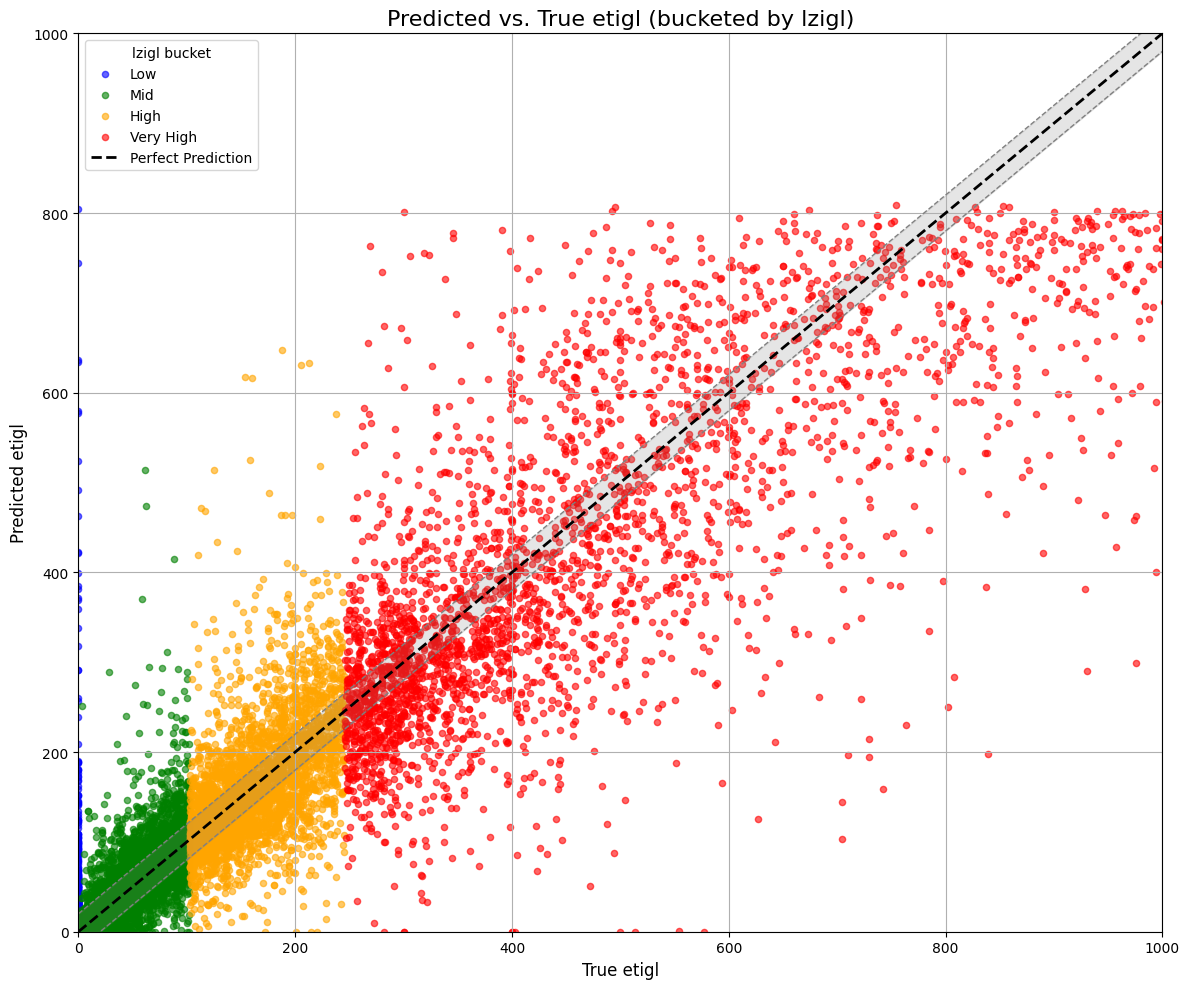


% of etigl predictions within ±20 per bucket:
Low      [0, 0]:  97.87% | count = 12889
Mid      [1, 102]:  86.78% | count = 14892
High     [103, 245]:  37.33% | count = 3472
Very High[246, 6684]:  13.10% | count = 3481

% of etigl predictions within ±50 per bucket:
Low      [0, 0]:  99.02% | count = 12889
Mid      [1, 102]:  97.54% | count = 14892
High     [103, 245]:  72.64% | count = 3472
Very High[246, 6684]:  31.60% | count = 3481


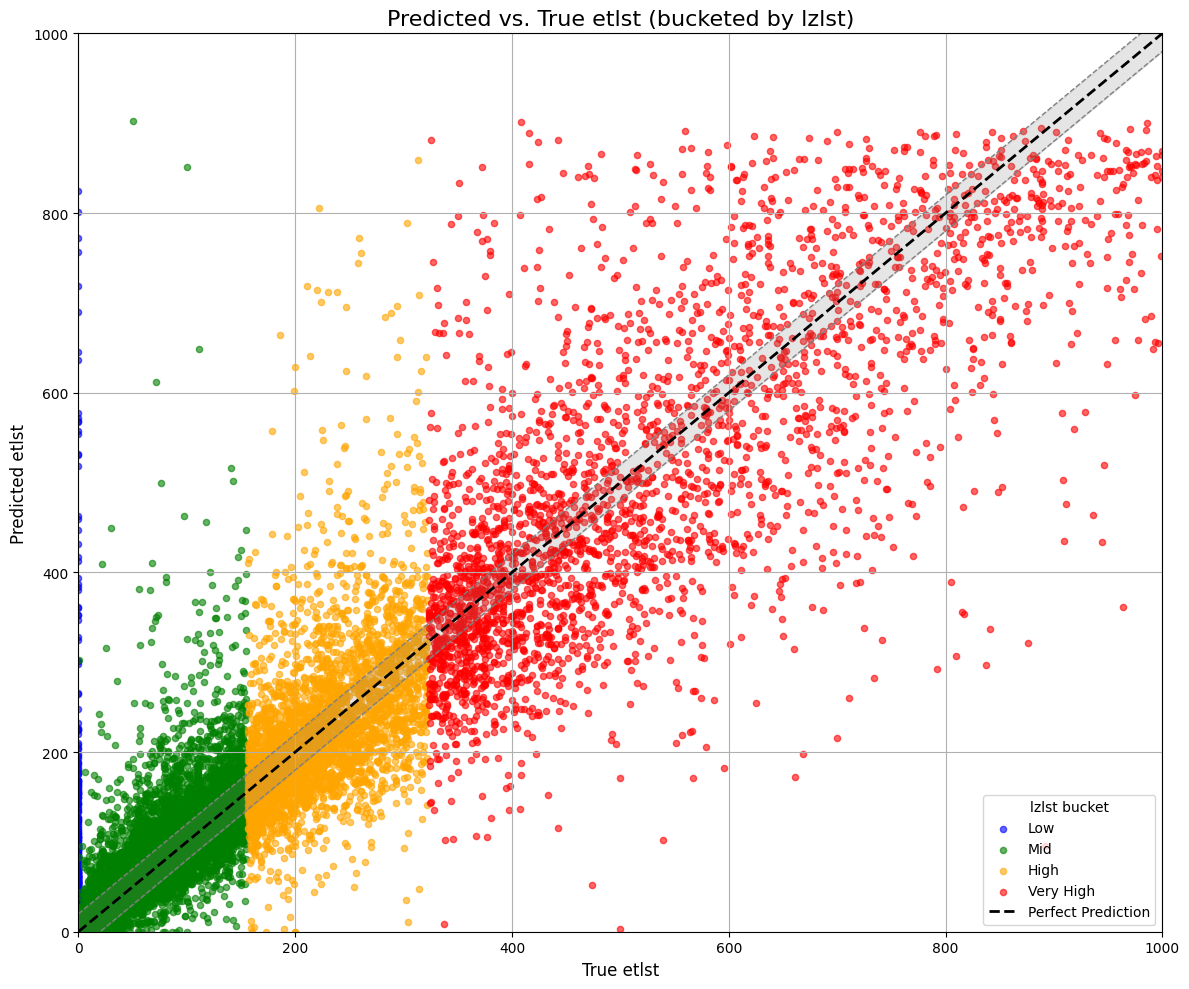


% of etlst predictions within ±20 per bucket:
Low      [0, 0]:  95.42% | count = 9140
Mid      [1, 155]:  80.02% | count = 18645
High     [156, 322]:  28.72% | count = 3461
Very High[323, 7260]:  11.61% | count = 3488

% of etlst predictions within ±50 per bucket:
Low      [0, 0]:  97.72% | count = 9140
Mid      [1, 155]:  94.81% | count = 18645
High     [156, 322]:  62.81% | count = 3461
Very High[323, 7260]:  29.79% | count = 3488


In [53]:
import numpy as np
import matplotlib.pyplot as plt

# --- Convert to numpy once ---
true_etigl = y_test[:, 0].cpu().numpy()
pred_etigl = y_pred_test[:, 0].cpu().numpy()
true_etlst = y_test[:, 1].cpu().numpy()
pred_etlst = y_pred_test[:, 1].cpu().numpy()

# --- Define buckets ---
def define_buckets(values):
    q20 = np.quantile(values, 0.2)
    q80 = np.quantile(values, 0.8)
    q90 = np.quantile(values, 0.9)
    buckets = {
        "Low":        values <= q20,
        "Mid":       (values > q20) & (values < q80),
        "High":      (values >= q80) & (values < q90),
        "Very High":  values >= q90
    }
    return buckets, (q20, q80, q90)

buckets_etigl, _ = define_buckets(true_etigl)
buckets_etlst, _ = define_buckets(true_etlst)

# --- Plot function (with ±20 band only) ---
def plot_pred_vs_true(true, pred, buckets, target_name, bucket_name, xlim=(0,1000), ylim=(0,1000)):
    colors = {"Low": "blue", "Mid": "green", "High": "orange", "Very High": "red"}
    
    plt.figure(figsize=(12, 10))
    for k, mask in buckets.items():
        plt.scatter(true[mask], pred[mask], label=k, color=colors[k], alpha=0.6, s=20)

    # Perfect prediction line and ±20 band
    x_vals = np.linspace(xlim[0], xlim[1], 500)
    plt.plot(x_vals, x_vals, 'k--', lw=2, label='Perfect Prediction')
    plt.plot(x_vals, x_vals + 20, color='gray', linestyle='--', lw=1)
    plt.plot(x_vals, x_vals - 20, color='gray', linestyle='--', lw=1)
    plt.fill_between(x_vals, x_vals - 20, x_vals + 20, color='gray', alpha=0.2)

    plt.title(f'Predicted vs. True {target_name} (bucketed by {bucket_name})', fontsize=16)
    plt.xlabel(f'True {target_name}', fontsize=12)
    plt.ylabel(f'Predicted {target_name}', fontsize=12)
    plt.legend(title=f'{bucket_name} bucket')
    plt.grid(True)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    plt.show()

# --- Function to print % of points within a band, including range ---
def print_within_band(true, pred, buckets, target_name, band):
    def pct_within_band(true, pred, mask, band):
        if mask.sum() == 0:
            return float('nan')
        return 100.0 * (np.abs(pred[mask] - true[mask]) <= band).mean()

    print(f"\n% of {target_name} predictions within ±{band} per bucket:")
    for k, mask in buckets.items():
        pct = pct_within_band(true, pred, mask, band)
        # compute bucket range
        if mask.sum() > 0:
            bucket_min = true[mask].min()
            bucket_max = true[mask].max()
        else:
            bucket_min = bucket_max = np.nan
        print(f"{k:9s}[{bucket_min:.0f}, {bucket_max:.0f}]: {pct:6.2f}% | count = {mask.sum()}")

# --- Plot & print for etigl ---
plot_pred_vs_true(true_etigl, pred_etigl, buckets_etigl, "etigl", "lzigl")
print_within_band(true_etigl, pred_etigl, buckets_etigl, "etigl", 20)
print_within_band(true_etigl, pred_etigl, buckets_etigl, "etigl", 50)

# --- Plot & print for etlst ---
plot_pred_vs_true(true_etlst, pred_etlst, buckets_etlst, "etlst", "lzlst")
print_within_band(true_etlst, pred_etlst, buckets_etlst, "etlst", 20)
print_within_band(true_etlst, pred_etlst, buckets_etlst, "etlst", 50)
